In [164]:
import torch as t
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from copy import copy
from torch.utils.data import DataLoader
from torch import nn
from sklearn.model_selection import train_test_split

## Предобработка данных

In [97]:
def aggregate_to_list(series): #aggregate function for group_by

    res = list(series)
    return res

In [206]:
def make_sparse_tensor(df, batch_size=50, part=0.8): #makes two sparse tensors: train and test 
    
    max_mov_id = df['movieId'].max()
    max_user_id = df['userId'].max()
    boundary = int(max_user_id * part)
    
    t_test = 0
    t_train = 0
    
    df['movieId'] = df['movieId'] - 1
    df['userId'] = df['userId'] - 1
    
    for i in range(0, max_user_id, batch_size):
        
        condition = (df.userId >= i) & (df.userId < i+batch_size)
        new_df = df[condition].groupby(by='userId', as_index=False)[['movieId', 'rating']].agg(aggregate_to_list)

        new_df['len'] = new_df['movieId'].apply(lambda x: len(x))
        new_df['indexes'] = new_df['userId'].apply(lambda x: [x])
        new_df['indexes'] = new_df['indexes'] * new_df['len']

        idx = new_df[['movieId', 'indexes', 'rating']].sum()
        indexes = np.asarray([np.asarray(idx['indexes'])-i, idx['movieId']])
        
        x_size = min(max_user_id - i, batch_size)
        y_size = max_mov_id
        
        t_part = t.sparse_coo_tensor(indexes, np.asarray(idx['rating']), (x_size, y_size),\
                                     requires_grad=False, dtype=t.float32)

        if i < boundary:
            t_train = t_part if isinstance(t_train, int) else t.vstack((t_train, t_part))
        elif i > boundary:
            t_test = t_part if isinstance(t_test, int) else t.vstack((t_test, t_part))
            
    return t_train, t_test

In [130]:
df = pd.read_csv("ratings.csv")
df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


Создание разреженных матриц происходит поэтапно. Из таблицы извлекается информация о части полизователей в количестве batch_size для них создается разреженная матрица и присоединяется к общей разреженной матрице. При грамотном выборе количества пользователей можно добиться ускорения обработки в два раза. Если общее число  пользователей было бы еще больше то ускоренее было бы еще более существенным. 

In [131]:
%%time
df = pd.read_csv("ratings.csv")
_ = make_sparse_tensor(df, batch_size=610)

CPU times: user 673 ms, sys: 123 ms, total: 797 ms
Wall time: 801 ms


In [132]:
%%time
df = pd.read_csv("ratings.csv")
_ = make_sparse_tensor(df, batch_size=20)

CPU times: user 558 ms, sys: 34.7 ms, total: 593 ms
Wall time: 581 ms


In [207]:
%%time
df = pd.read_csv("ratings.csv")
train_factor_matrix, test_factor_matrix = make_sparse_tensor(df, batch_size=90)
train_factor_matrix, test_factor_matrix

CPU times: user 331 ms, sys: 70.9 ms, total: 401 ms
Wall time: 456 ms


(tensor(indices=tensor([[    0,     0,     0,  ...,   539,   539,   539],
                        [    0,     2,     5,  ..., 45721, 48384, 48515]]),
        values=tensor([4., 4., 4.,  ..., 4., 4., 5.]),
        size=(540, 193609), nnz=84327, layout=torch.sparse_coo),
 tensor(indices=tensor([[     0,      0,      0,  ...,     69,     69,     69],
                        [     0,      6,      9,  ..., 168249, 168251, 170874]]),
        values=tensor([3., 4., 4.,  ..., 5., 5., 3.]),
        size=(70, 193609), nnz=16509, layout=torch.sparse_coo))

## Обучение модели

In [155]:
class RMSELoss(nn.Module): #Root mean square error loss
    
    def __init__(self, eps=1e-6):
        
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
        
    def forward(self, prediction, y):
        
        self.zeros = t.zeros(prediction.shape)
        prediction = t.where(y > 0, prediction, self.zeros)

        num = t.where(y > 0)[0].shape[0]
        loss = t.sqrt((prediction - y)**2 / (num + self.eps))

        return loss.sum()/prediction.shape[0] # mean loss for exact batch

In [56]:
class network_template(nn.Module): 
    
    def __init__(self, layers):
        
        super().__init__()
        self.layers = layers
        
    def forward(self, x):
        
        return self.layers(x)

ALS заключается в поочередной итеративной оптимизации матрицы характеристик пользователей U и матрицы характеристик фильмов V, в классе обучаются две нейрнных сети: одна получает наилучшее в среднеквадратичном смысле приближение матрицы факторов R оптимизируя матрицу U, вторая оптимизируя матрицу V. На каждой эпохе мы проходимся сначала по всем пользователям батчами размера u_batch затем по всем фильмам батчами размера v_batch. В список лоссов добавляется усредненные лоссы по всем батчам обоих моделей в одной эпохе (Возможно не совсем корректно усреднять лоссы по обеим моделям, но в целом динамику обучения это отражает. Такой способ подсчета лосса объясняет различие лоссов теста и трейна ведь в тесте лосс считается только по предсказанию U).

In [208]:
class rec_als_model:
    
    def __init__(self, factor_train, X_test, d=48, u_batch=48, v_batch=4096, learning_rate=0.005):
        
        self.factor_train = factor_train.float()
        self.X_test = X_test.float()
        
        self.x_size = factor_train.shape[0] # Data sizes
        self.y_size = factor_train.shape[1]
        self.d = d
        
        f_matr_copy_T = factor_train.clone().transpose_(1, 0)
        
        self.U_train_dataloader = DataLoader(factor_train, batch_size=u_batch, shuffle=False) # Dataloaders
        self.V_train_dataloader = DataLoader(f_matr_copy_T, batch_size=v_batch, shuffle=False)
        
        self.RMSE_loss = RMSELoss()
        self.learning_rate = learning_rate
        
        self.U = t.rand((self.x_size, d), requires_grad=False, dtype=t.float32) + 1 #U, V initialization
        self.V = t.rand((self.y_size, d), requires_grad=False, dtype=t.float32) + 1
        
        self.U_model = self.u_model_init()
        self.V_model = self.v_model_init()
        print('Models ready')
        
        self.u_optimizer = t.optim.Adam(self.U_model.parameters(), lr=self.learning_rate) # Optimizers
        self.v_optimizer = t.optim.Adam(self.V_model.parameters(), lr=self.learning_rate)
        print('Optimizers ready')

        
    def u_model_init(self):
        
        layers = nn.Sequential(nn.Linear(self.y_size, 2048),
                               nn.ELU(),
                               nn.Dropout(0.5),
                               nn.Linear(2048, 1024),
                               nn.ELU(),
                               nn.Dropout(0.5),
                               nn.Linear(1024, 256),
                               nn.ELU(),
                               nn.Dropout(0.5),
                               nn.Linear(256, self.d))
        
        return network_template(layers)

    
    def v_model_init(self): 
        
        layers = nn.Sequential(nn.Linear(self.x_size, self.x_size // 2),
                               nn.ELU(),
                               nn.Dropout(0.5),
                               nn.Linear(self.x_size // 2, self.x_size // 2),
                               nn.ELU(),
                               nn.Dropout(0.5),
                               nn.Linear(self.x_size // 2, self.x_size // 4),
                               nn.ELU(),
                               nn.Dropout(0.5),
                               nn.Linear(self.x_size // 4, self.d))
        
        return network_template(layers)
    
    
    def train(self, epochs=30): # Main training function
        
        losses_train = []
        losses_test = []
        
        for i in range(epochs):
            
            losses = []
            low_boundary = 0
            high_boundary = self.U_train_dataloader.batch_size
            
            for f_matr_part in self.U_train_dataloader: # training U_model
                
                self.u_optimizer.zero_grad()
                
                dense_matr = f_matr_part.to_dense()
                
                prediction = self.U_model.forward(dense_matr.float())
                self.U[low_boundary:high_boundary] = prediction
                
                loss = self.RMSE_loss.forward(prediction@(self.V.transpose(1, 0)), dense_matr)
                loss.backward()
                self.u_optimizer.step()
                
                low_boundary += self.U_train_dataloader.batch_size
                high_boundary += self.U_train_dataloader.batch_size
                
                losses.append(float(loss.data))
            
            self.U = self.U.detach()
            
            low_boundary = 0
            high_boundary = self.V_train_dataloader.batch_size
            
            for f_matr_part in self.V_train_dataloader: # training V_model
                
                self.v_optimizer.zero_grad()
                
                dense_matr = f_matr_part.to_dense()
                
                prediction = self.V_model.forward(dense_matr)
                self.V[low_boundary:high_boundary] = prediction
                
                loss = self.RMSE_loss.forward(self.U@(prediction.transpose(1, 0)), dense_matr.transpose(1, 0))
                loss.backward()
                self.v_optimizer.step()
                
                low_boundary += self.V_train_dataloader.batch_size
                high_boundary += self.V_train_dataloader.batch_size
                
                losses.append(float(loss.data))

            self.V = self.V.detach()
            
            loss = np.mean(np.asarray(losses))
            losses_train.append(loss)
            
            print('\nEpoch {}\nTrain loss = {}'.format(i, loss))
            
            test_loss = self.RMSE_loss.forward(self.forward(self.X_test.to_dense()), self.X_test.to_dense())
            losses_test.append(float(test_loss.data))
            print('Test loss = {}'.format(test_loss))
            
        return losses_train, losses_test
            
            
    def forward(self, x): # Fills gaps in factor matrix (predicts unknown ratings)
        
        prediction = self.U_model.forward(x.float())
        
        return prediction@(self.V.transpose(1, 0))

In [159]:
model = rec_als_model(train_factor_matrix, test_factor_matrix, learning_rate=0.001)

Models ready
Optimizers ready


In [160]:
losses_train, losses_test = model.train()


Epoch 0
Train loss = 4.594184825227907
Test loss = 5.498933792114258

Epoch 1
Train loss = 1.2693915363866837
Test loss = 8.580903053283691

Epoch 2
Train loss = 1.4715738965353617
Test loss = 4.095565319061279

Epoch 3
Train loss = 0.8884141005498046
Test loss = 3.634897232055664

Epoch 4
Train loss = 0.7977330410697808
Test loss = 3.935516357421875

Epoch 5
Train loss = 0.7855826668596516
Test loss = 2.562246799468994

Epoch 6
Train loss = 0.5972736026936522
Test loss = 2.302893877029419

Epoch 7
Train loss = 0.6042672509657374
Test loss = 2.2673022747039795

Epoch 8
Train loss = 0.5497232550677533
Test loss = 2.6335771083831787

Epoch 9
Train loss = 0.5800445766304619
Test loss = 2.39168643951416

Epoch 10
Train loss = 0.5430509688332676
Test loss = 2.5040476322174072

Epoch 11
Train loss = 0.5586147422203794
Test loss = 2.528024673461914

Epoch 12
Train loss = 0.5779523162908542
Test loss = 2.678508996963501

Epoch 13
Train loss = 0.5913791176009302
Test loss = 2.4293265342712402


In [204]:
def draw_graphs(losses_train, losses_test):
    
    plt.figure(figsize=(7, 7))

    plt.plot(losses_train, label="Train loss", c='y')
    plt.plot(losses_test, label="Test loss", c='r')
    plt.xlabel('Epoch')
    plt.ylabel('Avarage RMSE loss')
    plt.savefig("loss_graph.png", dpi = 800)
    
    plt.legend()

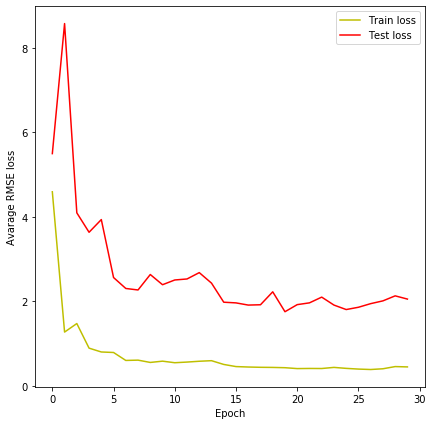

In [205]:
draw_graphs(losses_train, losses_test)

Пример выполнения функции forward для тестовых данных

In [166]:
test_dataloader = DataLoader(test_factor_matrix, batch_size=1, shuffle=False)
test_x = next(iter(test_dataloader))

In [184]:
prediction = model.forward(test_x)
prediction[:5], test_x.to_dense()[:5]

(tensor([[2.8347, 3.8024, 3.3003,  ..., 3.1376, 3.1183, 3.1832]],
        grad_fn=<SliceBackward>),
 tensor([[3., 0., 0.,  ..., 0., 0., 0.]]))

Сохраняем результат

In [203]:
res = pd.DataFrame({'Epoch': np.arange(30),
                    'Train_loss': np.asarray(losses_train),
                    'Test_loss': np.asarray(losses_test)})

res['Test_loss'] = res['Test_loss'].apply(lambda x: float(x.data))
res.to_csv('result.csv')